In [1]:
import numpy as np
import pandas as pd
import ast
from time_series_RAG import TimeSeriesRetriever, apply_kernel_with_noise
import matplotlib.pyplot as plt
import torch

/Users/zijielei/anaconda3/envs/time_series_RAG/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prep functions:

In [2]:
def plot_top_k_time_series(hist, top_k_indices):
    """
    Plots the top-k most similar time series clips.
    
    Parameters:
        hist (np.array): np array containing time series data.
        top_k_indices (list of tuples): List of (index, similarity score) pairs.
        k (int): Number of top similar time series to plot (default is 5).
    """
    
    plt.figure(figsize=(10, 6))
    for idx, sim in top_k_indices:
        print(f"Index: {idx}, Similarity: {sim:.4f}")
        plt.plot(hist[idx], label=f'Array {idx} (Sim: {sim:.4f})')
    
    # Labels and legend
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title(f"Plot of Retrieved Time Series Clips")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [ ]:
def percentage_in_range(index: int, fetch_indices: list) -> float:
    if not fetch_indices:
        return 0.0  # Avoid division by zero
    
    count_in_range = sum(index * 8 <= x <= index * 8 + 8 for x in fetch_indices)
    percentage = (count_in_range / len(fetch_indices)) * 100
    
    return percentage


In [ ]:
def compute_mean_percentage_in_range(hist, retriever, k=8):
    """
    Computes the mean percentage of retrieved top-k indices that fall within the valid range.

    Args:
        hist (list): List of time series history.
        retriever: An object that has a `retrieve_top_k` method.
        k (int): The number of top-k indices to retrieve.

    Returns:
        float: Mean percentage of retrieved indices in range.
    """
    percentages = []
    num_queries = len(hist)

    for index in range(num_queries):
        query_ts = hist[index]
        top_k_indices = retriever.retrieve_top_k(query_ts, k=k)
        percentage = percentage_in_range(index, [x[0] for x in top_k_indices])
        percentages.append(percentage)

        # Display progress
        progress = (index + 1) / num_queries * 100
        print(f"Progress: {progress:.2f}% completed", end="\r")

    mean_percentage = np.mean(percentages)
    print(f"\nMean Percentage in range: {mean_percentage:.2f}%")

    return mean_percentage

### Start:

In [3]:
df = pd.read_csv('data/MSPG.csv')
hist = np.vstack(df['Hist'].apply(lambda x: np.array(ast.literal_eval(x)[10:90])).to_numpy())
hist = hist[~np.all(hist == 0, axis=1)]

In [19]:
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

context = torch.tensor(hist[0:100])

# embeddings, tokenizer_state = pipeline.embed(context)
# embeddings.shape

np.vstack([pipeline.embed(torch.tensor(ts))[0].flatten(start_dim=1, end_dim=-1).float().numpy() for ts in final_noisy_data_reshaped]).shape

(400, 20736)

### Data aug and Benchmarking

In [46]:
kernel_types = ["original", "gaussian", "uniform", "laplace", "salt_and_pepper",
                "multiplicative", "exponential", "poisson"]

# Stack the noisy arrays
original_data = hist
noisy_data_list = []

for row in original_data:
    noisy_data = np.array([apply_kernel_with_noise(row, kernel_type=kernel) for kernel in kernel_types])
    noisy_data_list.append(noisy_data)

# Convert to final shape (8, m, n)
final_noisy_data = np.array(noisy_data_list)
final_noisy_data_reshaped = final_noisy_data.reshape(8 * original_data.shape[0], original_data.shape[1])

np.save("data/MSPG_aug_data", final_noisy_data_reshaped)

In [53]:
retriever = TimeSeriesRetriever(
    knowledge_source=final_noisy_data_reshaped, 
    # knowledge_output="data/MSPG_knowledge", 
    # feature_output="data/MSPG_features_chronos",
    # feature_source="data/MSPG_features_chronos.npy",
    alpha=0.2, 
    M=50,
    embedding_model="catch22"
)

In [ ]:
alpha = [0.0, 0.2, 0.5, 0.8, 1.0]
embedding_model = ['catch22', 'chronos']
for a in alpha:
    for embedding in embedding_model:
        retriever = TimeSeriesRetriever(
            knowledge_source=final_noisy_data_reshaped, 
            # knowledge_output="data/MSPG_knowledge", 
            # feature_output="data/MSPG_features_chronos",
            # feature_source="data/MSPG_features_chronos.npy",
            alpha=a, 
            M=50,
            embedding_model=embedding
        )
        print('Performance for Alpha:', a, 'Embedding:', embedding)
        print(compute_mean_percentage_in_range(hist, retriever, k=8))

In [ ]:
### Chronos Embeddings
percentages = []

for index in range(50):
    query_ts = hist[index]
    top_k_indices = retriever.retrieve_top_k(query_ts, k=8)
    percentage = percentage_in_range(index, [x[0] for x in top_k_indices])
    percentages.append(percentage)

mean_percentage = np.mean(percentages)
print(f"Mean Percentage in range: {mean_percentage:.2f}%")

Mean Percentage in range: 73.50%


Index: 8, Similarity: 1.0000
Index: 9, Similarity: 0.5846
Index: 11, Similarity: 0.5629
Index: 10, Similarity: 0.5534
Index: 13, Similarity: 0.5290
Index: 14, Similarity: 0.5149
Index: 32, Similarity: 0.4983
Index: 34, Similarity: 0.4979


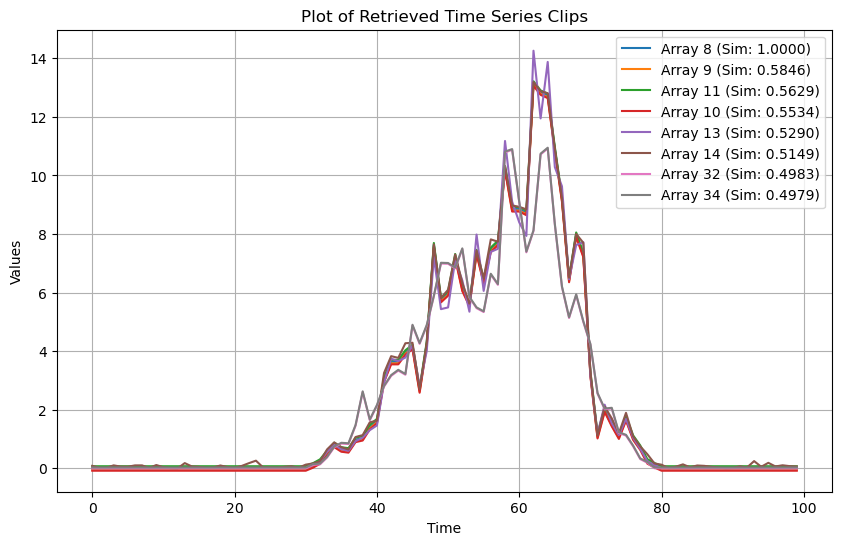

In [ ]:
plot_top_k_time_series(final_noisy_data_reshaped, top_k_indices)

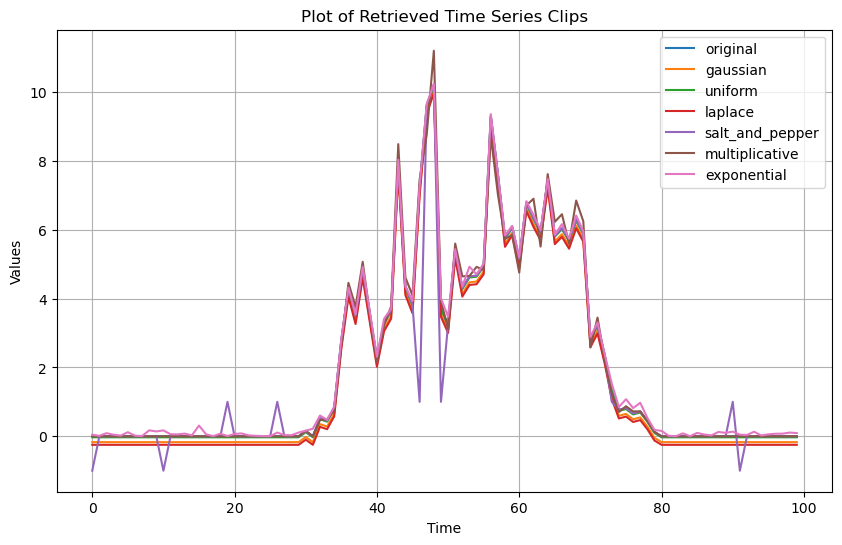

In [ ]:
idx = 100
plt.figure(figsize=(10, 6))
for idx in [0, 1, 2, 3, 4, 5, 6]:

    plt.plot(final_noisy_data_reshaped[idx], label=f'{kernel_types[idx]}')

# Labels and legend
plt.xlabel("Time")
plt.ylabel("Values")
plt.title(f"Plot of Retrieved Time Series Clips")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()